In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from scipy import io
import random
import numpy as np
import tensorflow as tf
import os
import sys
import pickle
import gzip
import random
import time
import shutil
import brain_python6 as bp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial import ConvexHull

n_times = 201
n_frequency = 79
n_outputs = 2

last_neurons = 40
n_neurons = [40,40,last_neurons]

want_accuracy = 1.0
last_accuracy = 0

max_load = 5
high_max_load = 10

load_number = ''

important_index = [105,125]
normal_range_index = [20,180]
window = 30
step = 1

data_base_path = "./brain_data8~50"

eeg = bp.brain_python(n_times,n_frequency,window,n_outputs)
label_list,_,_ = eeg.label_info(data_base_path)

train_data,train_data_label,_ = eeg.preprocessing(data_base_path)

final_data, final_data_label = eeg.data_multiple(train_data,train_data_label,label_list,important_index,normal_range_index,step)

batch_size = 20

action
normal


In [2]:
def intersection(linex1,liney1,linex2,liney2):
    f1 = (linex1[1]-linex1[0])*(liney2[0]-liney1[0])-(liney1[1]-liney1[0])*(linex2[0]-linex1[0])
    f2 = (linex1[1]-linex1[0])*(liney2[1]-liney1[0])-(liney1[1]-liney1[0])*(linex2[1]-linex1[0])
    f3 = (linex2[1]-linex2[0])*(liney1[0]-liney2[0])-(liney2[1]-liney2[0])*(linex1[0]-linex2[0])
    f4 = (linex2[1]-linex2[0])*(liney1[1]-liney2[0])-(liney2[1]-liney2[0])*(linex1[1]-linex2[0])
    
    if f1*f2<0 and f3*f4<0:
        return 1
    else :
        return 0
        
def intersection_dot(linex1,liney1,linex2,liney2):
        m1 = (liney1[1]-liney1[0])/(linex1[1]-linex1[0])
        m2 = (liney2[1]-liney2[0])/(linex2[1]-linex2[0])
        cx = (linex1[0]*m1-liney1[0]-linex2[0]*m2+liney2[0])/(m1-m2)
        cy = m1*(cx-linex1[0])+liney1[0]
        return np.array([[cx, cy]],float)
        
def intersection_inner(linex,liney,dot,max_dot):
        f1 = (linex[1]-linex[0])*(dot[1]-liney[0])-(liney[1]-liney[0])*(dot[0]-linex[0])
        f2 = (linex[1]-linex[0])*(dot[1]-liney[0])-(liney[1]-liney[0])*(max_dot-linex[0])
        f3 = (max_dot-dot[0])*(liney[0]-dot[1])-(dot[1]-dot[1])*(linex[0]-dot[0])
        f4 = (max_dot-dot[0])*(liney[1]-dot[1])-(dot[1]-dot[1])*(linex[1]-dot[0])

        if f1*f2<0 and f3*f4<0:
            return 1
        else :
            return 0

In [3]:
def pca_data(input_data):
    final_data = input_data
    # plus
    cut_times = 8
    stride = 2
    cluster_data = np.zeros([final_data.shape[0]*((final_data.shape[1]-cut_times+stride)//stride),cut_times,final_data.shape[2]])

    cluster_number = 0
    for input_data in final_data:
        for i in range(0,final_data.shape[1]-cut_times+stride,stride):
            cluster_data[cluster_number]=input_data[i:i+cut_times]
            cluster_number += 1

    action_cluster_data = cluster_data
    # action_cluster_data = cluster_data[:sum(train_data_label==[1,0])[0]*train_data.shape[1]//cut_times]


    scaler = StandardScaler()

    # action_cluster_data=np.transpose(action_cluster_data,(0,2,1))

    pca_1 = PCA(n_components=1)
    pca_2 = PCA(n_components=2)

    pc_data = np.zeros([action_cluster_data.shape[0],action_cluster_data.shape[1],1])
    for i in range(action_cluster_data.shape[0]):
        pc_data[i] = pca_1.fit_transform(action_cluster_data[i])
        
    pc_data = pc_data.reshape(pc_data.shape[0],pc_data.shape[1])
    pc_data = scaler.fit_transform(pc_data)

    pc = pca_2.fit_transform(pc_data)
    
    #normal outlier

    clf = LocalOutlierFactor(n_neighbors=int(pc.shape[0]*0.005),contamination='auto')
    outlier_index = clf.fit_predict(pc)
    pc = np.delete(pc,np.where(outlier_index==-1),axis=0)
    
    return pc

In [4]:
def IOU_score(pc1,pc2):
    pc1_hull = ConvexHull(pc1).simplices
    pc2_hull = ConvexHull(pc2).simplices

    IOU_dot = np.empty((0,2),float)
    for i in np.unique(pc2_hull):
        count=0
        for simplex1 in pc1_hull:
            count+=intersection_inner(pc1[simplex1,0],pc1[simplex1,1],pc2[i],9999)
        if count%2 == 1:
            IOU_dot = np.append(IOU_dot, pc2[i].reshape(-1,2), axis=0)

    for i in np.unique(pc1_hull):
        count=0
        for simplex2 in pc2_hull:
            count+=intersection_inner(pc2[simplex2,0],pc2[simplex2,1],pc1[i],9999)
        if count%2 == 1:
            IOU_dot = np.append(IOU_dot, pc1[i].reshape(-1,2), axis=0)

    for simplex1 in pc1_hull:

        for simplex2 in pc2_hull:

            if intersection(pc1[simplex1,0],pc1[simplex1,1],pc2[simplex2,0],pc2[simplex2,1]) == 1:
                intersection_point=intersection_dot(pc1[simplex1,0],pc1[simplex1,1],pc2[simplex2,0],pc2[simplex2,1])
                IOU_dot = np.append(IOU_dot,intersection_point,axis=0)

    for simplex1 in pc1_hull:
        plt.plot(pc1[simplex1,0],pc1[simplex1,1],'r--')

    for simplex2 in pc2_hull:
        plt.plot(pc2[simplex2,0],pc2[simplex2,1],'g--')

    for pointing in IOU_dot:
        plt.plot(pointing[0],pointing[1],'ro')
        
    plt.scatter(pc1[:,0],pc1[:,1],marker=".",s=50)
    plt.scatter(pc2[:,0],pc2[:,1],marker="+",s=10)

    plt.show()

    IOU_score=ConvexHull(IOU_dot).volume/(ConvexHull(pc1).volume+ConvexHull(pc2).volume-ConvexHull(IOU_dot).volume)
    
    return IOU_score

In [5]:
# Generator
Generator = tf.keras.Sequential()
Generator.add(layers.Dense(7*19*256,use_bias=False,input_shape=(100,)))
Generator.add(layers.BatchNormalization())
Generator.add(layers.LeakyReLU())

Generator.add(layers.Reshape((7,19,256)))

Generator.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
Generator.add(layers.BatchNormalization())
Generator.add(layers.LeakyReLU())

Generator.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
Generator.add(layers.BatchNormalization())
Generator.add(layers.LeakyReLU())

Generator.add(layers.Conv2DTranspose(1,(4,5),strides=(2,2),padding='valid',use_bias=False,activation='tanh'))
# Generator.add(layers.Reshape((30,79)))

In [6]:
Discriminator = tf.keras.Sequential()
Discriminator.add(layers.Conv2D(64, (5,5),strides=(2,2),padding='same',input_shape=[30,79,1]))

Discriminator.add(layers.LeakyReLU())
Discriminator.add(layers.Dropout(0.3))

Discriminator.add(layers.Conv2D(128, (5,5),strides = (2,2),padding = 'same'))
Discriminator.add(layers.LeakyReLU())
Discriminator.add(layers.Dropout(0.3))

Discriminator.add(layers.Flatten())
Discriminator.add(layers.Dense(1))

In [7]:
# define Optimizer
Doptimizer = tf.keras.optimizers.Adam(0.0001)
Goptimizer = tf.keras.optimizers.Adam(0.0001)

In [8]:
def get_noise(batch_size,n_noise):
    return tf.random.normal([batch_size,n_noise])

def train_step(inputs):

    with tf.GradientTape() as t1, tf.GradientTape() as t2:
        # 잡음으로부터 이미지 생성
        G = Generator(get_noise(inputs.shape[0],100))
#         G = Generator(noise)
        # 판별자 입력
        Z = Discriminator(G)
        R = Discriminator(inputs)   
        # 손실 함수 연산
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        loss_D = cross_entropy(tf.ones_like(R),R)+cross_entropy(tf.zeros_like(Z),Z)
        loss_G = cross_entropy(tf.ones_like(Z),Z)

    # 판별자 업데이트      
    Dgradients = t1.gradient(loss_D, Discriminator.trainable_variables)
    Doptimizer.apply_gradients(zip(Dgradients, Discriminator.trainable_variables))
    # 생성자 업데이트
    Ggradients = t2.gradient(loss_G,Generator.trainable_variables)
    Goptimizer.apply_gradients(zip(Ggradients, Generator.trainable_variables)) 
    return loss_D, loss_G,G,Z,R

In [9]:
final_data_limit=final_data

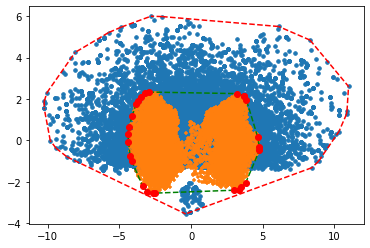

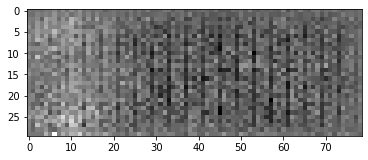

l_D: tf.Tensor(1.3793268, shape=(), dtype=float32)
l_G: tf.Tensor(0.74549395, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.10208511], shape=(1,), dtype=float32)
IOU_score: 0.2660682968840088


KeyboardInterrupt: 

In [12]:
# 배치 사이즈
total_batch = int(final_data_limit.shape[0]/batch_size) 
np_load_count = 0
number_of_load = 200
want_data = 2000
stop_per = 0

for epoch in tf.range(20000):
    for i in tf.range(total_batch):
        batch_input = final_data_limit[i*batch_size:(i+1)*batch_size]
        batch_input = np.reshape(batch_input,[-1,30,79,1])

        l_D,l_G,G_v,Z_v,R_v=train_step(batch_input)
        
        
# 생성된 이미지
    if epoch%1==0:
        G = Generator(get_noise(1,100))
        
        pc1=pca_data(final_data_limit)
        pc2=pca_data(np.reshape(Generator(get_noise(2000,100)),(-1,30,79)))
        IOU = IOU_score(pc1,pc2)
        if IOU>0.88:
            for np_load in range(number_of_load):
                G = Generator(get_noise(5,100))
                file_name = './gan_test/saved_'+str(np_load+np_load_count)
                np.save(file_name,G)
                stop_per = np_load+np_load_count
            np_load_count += number_of_load

        plt.imshow(np.reshape(G[0],(30,79)),interpolation="nearest",cmap='gray')
        plt.pause(0.001)
        print("l_D:",str(l_D))
        print("l_G:",str(l_G))
        print("Z_avr:",str(sum(Z_v)/Z_v.shape[0]))
        print("IOU_score:",str(IOU))
        plt.show()
        
    if stop_per >= want_data-1:
        break